In [14]:
# R2 department
feature_columns = df_parsed.department.unique()

for col in feature_columns:
    df_department[col] = df_department[col]/df_department['total_employees']

[data set from kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_movies.csv)

### Data Overview
* 2 files - 1 with full cast and crew credits other has movie metadata around the relase, language, popularity etc.
* file 1: credits
    * 4 columns, 4800 movies
    * 1 json of crew id/name/job and 1 json of cast character/actor/gender/id
* file 2: movie metadata
    * continuous variables: release_date, revenue, runtime, vote average (1-10), vote_count
    * categorical variables: genre (json needs parsing), keywords (thems like 'space war' also json), original language (mostly english), plot overview, production company, production_countries, 

# Scaling 
* StandardScaler -> features with a mean=0 and variance=1
* MinMaxScaler -> features in a 0 to 1 range
* Normalizer -> feature vector to a Euclidean length=1

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json
import time


from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer 
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, chi2, SelectFromModel
from sklearn.svm import SVR
import datetime
import matplotlib.pyplot as plt 
%matplotlib inline

___
# Functions for Parsing JSON


In [3]:
# Function for parsing credit files
def json_decode(data):
    movie_id_list = []
    credit_id_list = []
    department_list = []
    job_list = []    

    for n in np.arange(len(data)):
        json_cell = json.loads(data['crew'][n]) #convert to jsonjsonn from string
        for item in json_cell: #convert to list from json
            movie_id_list.append(data['movie_id'][n])
            credit_id_list.append(str(item['credit_id']))
            department_list.append(str(item['department']))
            job_list.append(str(item['job']))
        
    result = pd.DataFrame(data={'movie_id':movie_id_list,
                                'department':department_list,
                                'credit_id':credit_id_list,
                                'job':job_list})
    
    #job_count = pd.DataFrame(result.groupby('movie_id').count()['credit_id']).rename(columns={'credit_id':'people_count'}) 
    return result

In [4]:
def json_parse(data, column_name):
    universal_id_list = []
    column_name_list = []
    
    
    for n in np.arange(len(data)):
        json_cell = json.loads(data[column_name][n])
        for item in json_cell:
            universal_id_list.append(data['movie_id'][n])
            column_name_list.append(str(item['name']))
    df_parsed = pd.DataFrame(data={'movie_id':universal_id_list,
                                str(column_name):column_name_list})
    total_column_name = 'total_'+str(column_name)
    df_parsed[total_column_name] = 1
    total_columns = df_parsed.groupby('movie_id').sum()[total_column_name]
    df_parsed = df_parsed.pivot_table(index=['movie_id'], 
                                        columns=[column_name],  
                                      fill_value=0)[total_column_name]
    result = df_parsed.join(total_columns, on='movie_id', how='inner')
    return result    

# Function to create feature importance list
def print_feature_importance(X_train, model_object):
    features = pd.DataFrame(data={'features':X_train.columns, 
                                  'feature_importance':model_object.best_estimator_.feature_importances_})
    return features.sort_values(by='feature_importance', ascending=False).reset_index(drop=True)

___
# Import & Clean Data

In [5]:
# Import Movie Dataset
df_movies = pd.DataFrame(pd.read_csv('~/dev/thinkful_data/unit_3/tmdb/tmdb_5000_movies.csv'))
df_movies = df_movies.rename(columns={'id':'movie_id'})

# Data Cleaning
df_movies = df_movies[df_movies['vote_count']>50]
df_movies = df_movies[df_movies['budget']>0]
df_movies = df_movies[df_movies['runtime']>60]
df_movies['runtime'] = df_movies['runtime'].apply(lambda x: x/60.0)
df_movies = df_movies[df_movies['release_date']>='2000-01-01']

# Conter date and add date related features
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])
df_movies['month']=df_movies['release_date'].apply(lambda x: x.month_name())
df_movies['year']=df_movies['release_date'].apply(lambda x: x.year)
df_movies['random_number'] = np.random.rand(len(df_movies['vote_average']),1)

# Parse Genres
df_movies = df_movies.sort_values(by='random_number')
df_movies = df_movies.reset_index(drop=True)
df_genres = json_parse(df_movies, 'genres')

# Select base metrics for df_movies
df_movies = df_movies[['movie_id','title', 'vote_average', 'budget', 'runtime', 'year', 'month']].set_index('movie_id')

# Join base metrics for df_movies to df_genres
df_genres = df_movies.join(df_genres, on='movie_id', how='left')

In [6]:
df_credits = pd.DataFrame(pd.read_csv('~/dev/thinkful_data/unit_3/tmdb/tmdb_5000_credits.csv'))
# parse credits file
df_parsed = json_decode(df_credits)
df_parsed['job'] = df_parsed['job'].str.replace(' ', '_').apply(
    lambda x: str.lower(x)+'_job')
df_parsed['department'] = df_parsed['department'].str.replace(' & ','_').str.replace('-','_').str.replace(' ','_').apply(lambda x: str.lower(x)+'_dept')
df_parsed = df_parsed[df_parsed['department']!='actors_dept'].reset_index(drop=True)

employee_count = pd.DataFrame(df_parsed.groupby(['movie_id']).count()['credit_id'])
employee_count = employee_count.rename(columns={'credit_id':'total_employees'})

# calculate pivot parsed jobs
df_job = df_parsed.pivot_table(index=['movie_id'], 
                                  columns=['job'], 
                                  aggfunc='count', 
                                  fill_value=0)['credit_id']

# calculate pivot parsed department
df_department = df_parsed.pivot_table(index=['movie_id'], 
                                  columns=['department'], 
                                  aggfunc='count', 
                                  fill_value=0)['credit_id']

df_job = df_movies.join(
    employee_count, on='movie_id', how='inner').join(
    df_department, how='inner', on='movie_id').join(
    df_job, on='movie_id', how='inner')

# Mix up order
df_job['random_number'] = np.random.rand(len(df_job['vote_average']),1)
df_job = df_job.sort_values(by='random_number')
df_job = df_job.drop(columns='random_number', axis=1)
df_job = pd.get_dummies(data=df_job, columns=['month'])

In [18]:
df_job.sort_values(by=['thanks_job'], ascending=False)[['title', 'vote_average','thanks_job']]

,title,vote_average,thanks_job
movie_id,,,
2749,15 Minutes,5.7,13
55,Amores perros,7.6,13
74643,The Artist,7.3,13
68718,Django Unchained,7.8,8
153,Lost in Translation,7.3,8
2359,Sicko,7.3,7
150540,Inside Out,8.0,6
106646,The Wolf of Wall Street,7.9,6
16869,Inglourious Basterds,7.9,5


In [7]:
job_features = df_parsed.job.unique()
department_features = df_parsed.department.unique()
basic_features =['runtime', 'budget', 'month']
#test_features = pd.read_pickle('test_features.pickle')
features = df_job.columns
features = features.drop(['vote_average', 'title'])
test_features = df_job[features].var().sort_values()[200:].index
job_features = np.concatenate([job_features]+[department_features])

-------
# Gradient Boost Winning Model

In [8]:
X = df_job[test_features]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = df_job['vote_average']

gbr = GradientBoostingRegressor(max_depth=4, 
                            n_estimators=135,
                               subsample=0.3,
                               learning_rate=0.03) 
gbr_fit = gbr.fit(X_scaled, y)
y_predict = gbr_fit.predict(X_scaled)

output = pd.DataFrame(data={'actual':y, 'prediction':y_predict})

output['residuals'] = output['prediction']-output['actual']

In [12]:
gbr_cv = cross_val_score(gbr, X, y, cv=3, scoring='r2')
print("Mean: %.3f"% gbr_cv.mean())
print("St dev: %.3f"% np.std(gbr_cv))

Mean: 0.301
St dev: 0.017


In [15]:
gbr_cv = cross_val_score(gbr, X, y, cv=3, scoring='neg_mean_squared_error')
gbr_cv_root = np.sqrt(gbr_cv*(-1))
print("Mean: %.3f"% gbr_cv_root.mean())
print("St dev: %.3f"% np.std(gbr_cv_root))

Mean: 0.684
St dev: 0.005


In [14]:
gbr_cv_root.mean()

array([0.67726525, 0.68519587, 0.68843767])

In [70]:
output.head()

,actual,prediction,residuals
movie_id,,,
87567,5.7,5.595670,-0.104330
12177,4.3,5.374631,1.074631
9928,6.0,6.164524,0.164524
109421,6.4,6.061296,-0.338704
8836,5.5,6.075203,0.575203


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


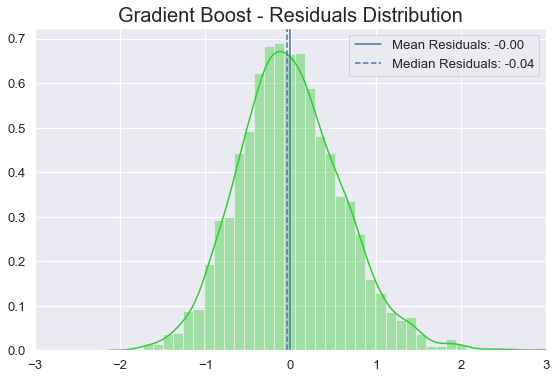

In [87]:
def plot_histogram(data, variable, title):
    # Calculate Descriptive Features
    mean = data.mean()
    median = np.median(data)
    st_dev = np.std(data)
    
    # Set Style of Histogram
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.2,style='darkgrid' )
    ax = sns.distplot(data, color='limegreen', bins=40)
    
    # Set Label Names and Label Font
    ax.set(xlabel='', 
           ylabel=''
           ,xlim=(-3,3))
    ax.set_title(title, fontsize=20)
    
    # Add Vertical Lines and Legend
    axv1 = ax.axvline(mean, label='Mean %s: %4.2f'%(variable, mean))
    axv2 = ax.axvline(median, label='Median %s: %4.2f'%(variable, median), linestyle='--')
#     axv3 = ax.axvline((mean+st_dev), linestyle='--')
#     axv4 = ax.axvline((mean-st_dev), linestyle='--')
    ax.legend()
    
    # Finalize the plot
    #sns.despine(trim=True)
    plt.tight_layout(h_pad=2)
plot_histogram(output['residuals'], 'Residuals', 'Gradient Boost - Residuals Distribution')

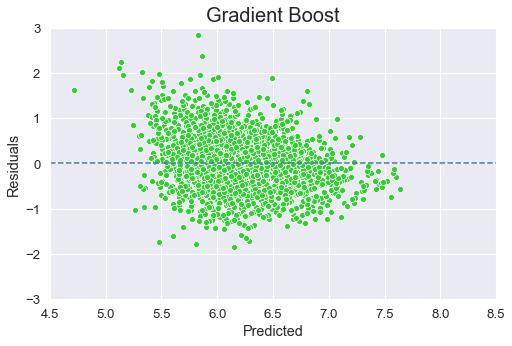

In [34]:
def scatter(data,x,y, title):    
    # Set Style of Histogram
    plt.figure(figsize=(8,5))
    sns.set(font_scale=1.2, style='darkgrid' )
    ax = sns.scatterplot(data=data, x=x, y=y, color='limegreen')
    
    # Set Label Names and Label Font
    ax.set(xlabel='Predicted', 
           ylabel='Residuals',
           ylim=(-3,3)
           ,xlim=(4.5,8.5)
          )
    ax.set_title(title, fontsize=20)
    ax.axhline(y=0, linestyle='--')
   
    # Finalize the plot
    #sns.despine(trim=True)

scatter(data=output, x='prediction', y='residuals', title='Gradient Boost')

#### def scatter(data,x,y, title):    
    # Set Style of Histogram
    plt.figure(figsize=(8,8))
    sns.set(font_scale=1.2, style='darkgrid' )
    ax = sns.scatterplot(data=data, x=x, y=y, color='limegreen')
    
    # Set Label Names and Label Font
    ax.set(xlabel='Predicted', 
           ylabel='Actual',
            ylim=(2,9)
            ,xlim=(2,9)
           )
    ax.set_title(title, fontsize=20)
#     ax.axhline(y=0, linestyle='--')
   
    # Finalize the plot
    #sns.despine(trim=True)

scatter(data=output, x='prediction', y='actual', title='Gradient Boost')

# Graphing

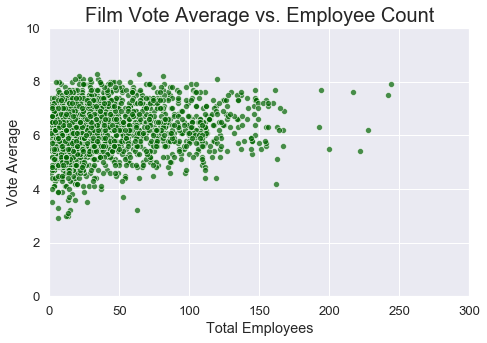

In [150]:
# Set Style of Histogram
plt.figure(figsize=(7,5))
sns.set(font_scale=1.2,style='darkgrid' )

ax = sns.scatterplot(y='vote_average', x='total_employees',color='darkgreen', data=df_job, alpha=.7)
ax.set(xlabel='Total Employees', ylabel='Vote Average',
       ylim= (0,10),
       xlim=(0,300))
ax.set_title('Film Vote Average vs. Employee Count', fontsize=20)
plt.tight_layout(h_pad=2)

plt.show()

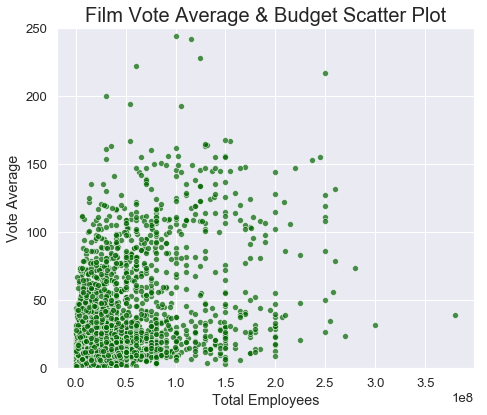

In [137]:
# Set Style of Histogram
plt.figure(figsize=(7,6))
sns.set(font_scale=1.2,style='darkgrid' )

ax = sns.scatterplot(x='budget', y='total_employees',color='darkgreen', data=df_job, alpha=.7)
ax.set(xlabel='Total Employees', ylabel='Vote Average',
#        ylim= (0,10),
       ylim=(0,250))
ax.set_title('Film Vote Average & Budget Scatter Plot', fontsize=20)
plt.tight_layout(h_pad=2)

plt.show()

In [201]:
df_stacked = df_parsed.groupby(['movie_id', 'department']).count()['credit_id'].reset_index()
df_stacked = df_stacked.join(df_stacked.groupby('movie_id').sum()['credit_id'], on='movie_id', how='inner', rsuffix='_total')

df_stacked['percent'] = df_stacked['credit_id']/df_stacked['credit_id_total']

In [202]:
df_stacked.head()

,movie_id,department,credit_id,credit_id_total,percent
0,5,art_dept,10,88,0.113636
1,5,camera_dept,8,88,0.090909
2,5,costume_make_up_dept,7,88,0.079545
3,5,crew_dept,16,88,0.181818
4,5,directing_dept,7,88,0.079545


In [167]:
order = df_department_count.groupby('department').mean().sort_values(by='credit_id',ascending=False).index

In [166]:
df_department_count.groupby('department').mean().sort_values(by='credit_id',ascending=False)

,movie_id,credit_id
department,,
production_dept,50392.154179,7.052752
crew_dept,57089.486446,6.940763
visual_effects_dept,62048.302888,5.896175
art_dept,50877.890854,4.957610
sound_dept,47963.664837,4.440296
costume_make_up_dept,51505.562500,4.289877
lighting_dept,65224.237136,2.695749
camera_dept,47185.876971,2.591216
writing_dept,54846.638646,2.333624


In [164]:
order

Index(['production_dept', 'sound_dept', 'art_dept', 'crew_dept',
       'costume_make_up_dept', 'writing_dept', 'camera_dept', 'directing_dept',
       'editing_dept', 'visual_effects_dept', 'lighting_dept'],
      dtype='object', name='department')

In [178]:
labels = []
for x in order:
    labels.append(x[:-5])


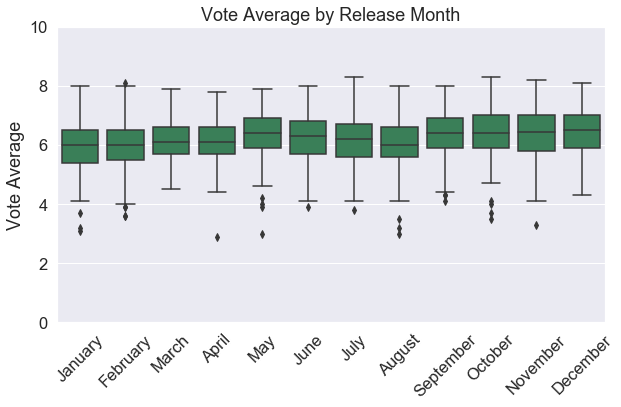

In [258]:
# df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])
# df_movies['month']=df_movies['release_date'].apply(lambda x: x.month_name())
labels=['January','February','March','April','May','June','July', 
       'August', 'September', 'October', 'November', 'December']

def plot_me(data, x, y, kind):
    plt.figure(figsize=(9,6))
    sns.set(font_scale=1.5,style='darkgrid' )

    ax = sns.boxplot(x=x, y=y, color='seagreen',order=order, data=data)
    ax.set(xlabel='', 
           ylabel='Vote Average',
           ylim=(0,10))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_title('Vote Average by Release Month', fontsize=18)

    plt.tight_layout(h_pad=2)


plot_me(df_movies, 'month','vote_average', 'box')

Index(['production_dept', 'writing_dept', 'directing_dept', 'art_dept',
       'sound_dept', 'crew_dept', 'costume_make_up_dept',
       'visual_effects_dept', 'camera_dept', 'editing_dept', 'lighting_dept'],
      dtype='object', name='department')

In [209]:
df_stacked.groupby('department').median().sort_values(by='percent',ascending=False)

,movie_id,credit_id,credit_id_total,percent
department,,,,
production_dept,11619.5,6.0,19.5,0.250000
art_dept,11455.0,3.0,26.0,0.121212
writing_dept,13943.0,2.0,17.0,0.117647
sound_dept,11283.0,2.0,21.0,0.111111
crew_dept,12473.0,3.0,38.0,0.102564
costume_make_up_dept,11455.0,3.0,28.0,0.086957
directing_dept,14517.0,1.0,16.0,0.083333
camera_dept,11146.5,1.0,21.0,0.076190
editing_dept,11102.5,1.0,21.0,0.071429


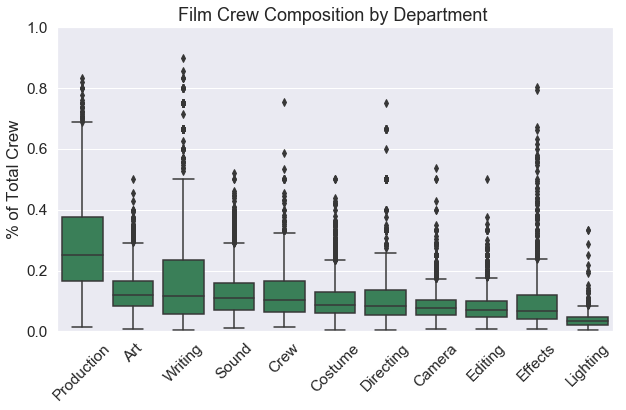

In [259]:
order = df_stacked.groupby('department').median().sort_values(by='percent',ascending=False).index
#plot_types = ['swarm','violin', 'boxen', 'point', 'bar']
labels = ['Production','Art', 'Writing', 'Sound', 'Crew', 
          'Costume','Directing', 'Camera', 'Editing', 'Effects',  'Lighting' ]
def plot_me(data, x,y, kind):
    plt.figure(figsize=(9,6))
    sns.set(font_scale=1.4,style='darkgrid' )

    ax = sns.boxplot(x=x, y=y, color='seagreen',order=order, data=data)
    ax.set(xlabel='', 
           ylabel='% of Total Crew',
           ylim=(0,1))
    ax.set_xticklabels(labels, rotation=45)

    ax.set_title('Film Crew Composition by Department ', fontsize=18)

    plt.tight_layout(h_pad=2, w_pad=2)


plot_me(df_stacked[df_stacked['percent']<1], x='department',y='percent', kind='box')

# Feature selection F-test

In [128]:
lr = LinearRegression()
scaler = MinMaxScaler()
training_scaled = pd.DataFrame(scaler.fit_transform(df_job[test_features]), 
                               columns=test_features)

In [129]:
chi2_val, pval = f_regression(training_scaled, df_job['vote_average'])
p_df = pd.DataFrame(pval.T, index=test_features, columns=['p'])

In [130]:
for alpha in [.001, .01, .05, .1]:
    selected = p_df[p_df['p'] < alpha]
    lr.fit(X, y)
    print('alpha {}, with {} features, mean accuracy {}'.format(
        alpha,
        len(selected.index),
        cross_val_score(lr, X[selected.index], y).mean()))

alpha 0.001, with 58 features, mean accuracy 0.21343378075086603
alpha 0.01, with 84 features, mean accuracy 0.21644344582445196
alpha 0.05, with 111 features, mean accuracy 0.21905796872727748
alpha 0.1, with 135 features, mean accuracy 0.19679788174292634


In [131]:
p_df.sort_values('p')[:25]

,p
runtime,1.830578e-102
assistant_director_job,4.449583e-19
thanks_job,1.898448e-13
editing_dept,3.443820e-13
novel_job,3.053093e-11
production_dept,1.980016e-10
sound_dept,4.044610e-10
total_employees,4.117877e-10
assistant_editor_job,1.383773e-09
post_production_supervisor_job,6.590171e-09


In [194]:
lr = LinearRegression()
scaler = MinMaxScaler()
training_scaled = pd.DataFrame(scaler.fit_transform(df_job[job_features]), 
                               columns=job_features)

chi2_val, pval = f_regression(training_scaled, df_job['vote_average'])
p_df = pd.DataFrame(pval.T, index=job_features, columns=['p'])

for alpha in [.001, .01, .05, .1]:
    selected = p_df[p_df['p'] < alpha]
    lr.fit(X, y)
    print('alpha {}, with {} features, mean accuracy {}'.format(
        alpha,
        len(selected.index),
        cross_val_score(lr, df_job[selected.index], df_job['vote_average']).mean()))

/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


alpha 0.001, with 57 features, mean accuracy 0.05840390229695976
alpha 0.01, with 89 features, mean accuracy 0.05055008011330616
alpha 0.05, with 129 features, mean accuracy 0.033684739118739516
alpha 0.1, with 162 features, mean accuracy 2.5422645434036717e-05


In [195]:
p_df.sort_values('p')[:25]

,p
assistant_director_job,4.449583e-19
thanks_job,1.898448e-13
editing_dept,3.443820e-13
novel_job,3.053093e-11
production_dept,1.980016e-10
sound_dept,4.044610e-10
assistant_editor_job,1.383773e-09
post_production_supervisor_job,6.590171e-09
foley_job,1.190759e-08
production_design_job,2.628145e-08


In [203]:
# Department/job only


training_scaled = scaler.fit_transform(df_job[job_features])

pipeline = Pipeline([
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest()),
    ('clf', LinearRegression())
])

parameters = {
    'threshold__threshold': (.0005,.001,.0001),
    'features__k': ('all',100,75, 50,30, 20),
    'features__score_func': (f_regression,),
}

grid_search = GridSearchCV(pipeline, parameters, verbose=1,
                           refit=True, scoring='neg_mean_squared_error')
grid_search.fit(training_scaled, df_job['vote_average'])

print( 'Best score: %.3f'%(grid_search.best_score_))
print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: {}'.format(grid_search.best_estimator_.get_params()))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best score: -0.634
Best score: 0.796
Best parameters: {'memory': None, 'steps': [('threshold', VarianceThreshold(threshold=0.0005)), ('features', SelectKBest(k=30, score_func=<function f_regression at 0x1a17129bf8>)), ('clf', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))], 'threshold': VarianceThreshold(threshold=0.0005), 'features': SelectKBest(k=30, score_func=<function f_regression at 0x1a17129bf8>), 'clf': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), 'threshold__threshold': 0.0005, 'features__k': 30, 'features__score_func': <function f_regression at 0x1a17129bf8>, 'clf__copy_X': True, 'clf__fit_intercept': True, 'clf__n_jobs': 1, 'clf__normalize': False}


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    2.0s finished


In [191]:
# Department/job only


training_scaled = scaler.fit_transform(df_job[job_features])

pipeline = Pipeline([
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest()),
    ('clf', LinearRegression())
])

parameters = {
    'threshold__threshold': (.001,.003),
    'features__k': ('all',50),
    'features__score_func': (f_regression,),
}

grid_search = GridSearchCV(pipeline, parameters, verbose=1,
                           refit=True, scoring='neg_mean_squared_error')
grid_search.fit(training_scaled, df_job['vote_average'])

print( 'Best score: %.3f'%(grid_search.best_score_))
print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: {}'.format(grid_search.best_estimator_.get_params()))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best score: -0.641
Best score: 0.801
Best parameters: {'memory': None, 'steps': [('threshold', VarianceThreshold(threshold=0.001)), ('features', SelectKBest(k=50, score_func=<function f_regression at 0x1a17129bf8>)), ('clf', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))], 'threshold': VarianceThreshold(threshold=0.001), 'features': SelectKBest(k=50, score_func=<function f_regression at 0x1a17129bf8>), 'clf': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), 'threshold__threshold': 0.001, 'features__k': 50, 'features__score_func': <function f_regression at 0x1a17129bf8>, 'clf__copy_X': True, 'clf__fit_intercept': True, 'clf__n_jobs': 1, 'clf__normalize': False}


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.5s finished


In [145]:
# test_features

training_scaled = scaler.fit_transform(df_job[test_features])

pipeline = Pipeline([
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest()),
    ('clf', LinearRegression())
])

parameters = {
    'threshold__threshold': (.001,),
    'features__k': (100,),
    'features__score_func': (f_regression,),
}

grid_search = GridSearchCV(pipeline, parameters, verbose=1,
                           refit=True, scoring='neg_mean_squared_error')
grid_search.fit(training_scaled, df_job['vote_average'])

print( 'Best score: %.3f'%(grid_search.best_score_))
print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: {}'.format(grid_search.best_estimator_.get_params()))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: -0.534
Best score: 0.731
Best parameters: {'memory': None, 'steps': [('threshold', VarianceThreshold(threshold=0.001)), ('features', SelectKBest(k=100, score_func=<function f_regression at 0x1a17129bf8>)), ('clf', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))], 'threshold': VarianceThreshold(threshold=0.001), 'features': SelectKBest(k=100, score_func=<function f_regression at 0x1a17129bf8>), 'clf': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), 'threshold__threshold': 0.001, 'features__k': 100, 'features__score_func': <function f_regression at 0x1a17129bf8>, 'clf__copy_X': True, 'clf__fit_intercept': True, 'clf__n_jobs': 1, 'clf__normalize': False}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [145]:
training_scaled = scaler.fit_transform(df_job[test_features])

pipeline = Pipeline([
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest()),
    ('clf', LinearRegression())
])

parameters = {
    'threshold__threshold': (.001,),
    'features__k': (100,),
    'features__score_func': (f_regression,),
}

grid_search = GridSearchCV(pipeline, parameters, verbose=1,
                           refit=True, scoring='neg_mean_squared_error')
grid_search.fit(training_scaled, df_job['vote_average'])

print( 'Best score: %.3f'%(grid_search.best_score_))
print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: {}'.format(grid_search.best_estimator_.get_params()))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: -0.534
Best score: 0.731
Best parameters: {'memory': None, 'steps': [('threshold', VarianceThreshold(threshold=0.001)), ('features', SelectKBest(k=100, score_func=<function f_regression at 0x1a17129bf8>)), ('clf', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))], 'threshold': VarianceThreshold(threshold=0.001), 'features': SelectKBest(k=100, score_func=<function f_regression at 0x1a17129bf8>), 'clf': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), 'threshold__threshold': 0.001, 'features__k': 100, 'features__score_func': <function f_regression at 0x1a17129bf8>, 'clf__copy_X': True, 'clf__fit_intercept': True, 'clf__n_jobs': 1, 'clf__normalize': False}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [276]:

# random forest + test features

scaled_data = scaler.fit_transform(df_job[test_features])

pipeline = Pipeline([
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', RandomForestRegressor(n_jobs=-1))
])

parameters = {
    'threshold__threshold': (.001, .002),
    'features__k': ( 'all',100,),
    'clf__max_depth': (9,4),
    'clf__n_estimators': (100,)
}
    
grid_search = GridSearchCV(pipeline, parameters, verbose=1,
                           refit=True, scoring='neg_mean_squared_error')
grid_search.fit(scaled_data, df_job['vote_average'])
print( 'Best score: {}'.format(grid_search.best_score_))
print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: {}'.format(grid_search.best_estimator_.get_params()))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   15.3s finished


Best score: -0.4844207463116126
Best score: 0.696
Best parameters: {'memory': None, 'steps': [('threshold', VarianceThreshold(threshold=0.001)), ('features', SelectKBest(k='all', score_func=<function f_regression at 0x1a17129bf8>)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))], 'threshold': VarianceThreshold(threshold=0.001), 'features': SelectKBest(k='all', score_func=<function f_regression at 0x1a17129bf8>), 'clf': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split

In [211]:
# random forest + job features

scaled_data = scaler.fit_transform(df_job[job_features])

pipeline = Pipeline([
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', RandomForestRegressor(n_jobs=-1))
])

parameters = {
    'threshold__threshold': (.001, ),
    'features__k': ( 100,),
    'clf__max_depth': (9,),
    'clf__n_estimators': (100,)
}
    
grid_search = GridSearchCV(pipeline, parameters, verbose=1,
                           refit=True, scoring='neg_mean_squared_error')
grid_search.fit(scaled_data, df_job['vote_average'])
print( 'Best score: {}'.format(grid_search.best_score_))
print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: {}'.format(grid_search.best_estimator_.get_params()))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s finished


Best score: -0.6130465842087052
Best score: 0.783
Best parameters: {'memory': None, 'steps': [('threshold', VarianceThreshold(threshold=0.001)), ('features', SelectKBest(k=100, score_func=<function f_regression at 0x1a17129bf8>)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))], 'threshold': VarianceThreshold(threshold=0.001), 'features': SelectKBest(k=100, score_func=<function f_regression at 0x1a17129bf8>), 'clf': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,


In [141]:
pipeline = Pipeline([
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', RandomForestRegressor(n_jobs=-1))
])

parameters = {
    'threshold__threshold': (.002, .005),
    'features__k': (100, 50, 10),
    'clf__max_depth': (3,5,None),
    'clf__n_estimators': (10,50,)
}
    
grid_search = GridSearchCV(pipeline, parameters, verbose=1)
grid_search.fit(scaled_data, df_job['vote_average'])
print( 'Best score: {}'.format(grid_search.best_score_))
print( 'Best parameters: {}'.format(grid_search.best_estimator_.get_params()))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   41.3s finished


Best score: 0.22290627318366057
Best parameters: {'memory': None, 'steps': [('threshold', VarianceThreshold(threshold=0.005)), ('features', SelectKBest(k=100, score_func=<function f_regression at 0x1a17129bf8>)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))], 'threshold': VarianceThreshold(threshold=0.005), 'features': SelectKBest(k=100, score_func=<function f_regression at 0x1a17129bf8>), 'clf': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weig

In [89]:
# Scale it again to be safe
scaled_data = scaler.fit_transform(df_job[features])

# This does solidly well
model_selector = SelectFromModel(RandomForestRegressor(max_depth=9))
training_from_rf = pd.DataFrame(model_selector.fit_transform(
    scaled_data, df_job['vote_average']), columns=
cross_val_score(lr, training_from_rf, df_job['vote_average'])

# # Include a threshold? no real difference
# model_selector = SelectFromModel(RandomForestClassifier(), threshold='mean')
# training_from_rf = model_selector.fit_transform(
#     scaled_data, using['churned'])
# cross_val_score(logistic, training_from_rf, using['churned'])

array([0.22243262, 0.27844184, 0.11681179])

______
# Base Model Predicting Vote Average

In [142]:
# Define targe and features for this code block
X = df_movies[['runtime',  'budget', 'month','year']]
X = pd.get_dummies(X)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = df_movies['vote_average']


lr = LinearRegression()
print(cross_val_score(lr, X, y, cv=5, scoring='r2').mean())
print(np.sqrt(cross_val_score(lr, X_scaled, y, cv=5, scoring='neg_mean_squared_error').mean()*(-1)))
print(cross_val_score(lr, X_scaled, y, cv=5, scoring='r2').mean())
print(cross_val_score(lr, X_scaled, y, cv=5, scoring='neg_mean_squared_error'))

0.18780880698196195
0.7359789050307175
0.18878230676367003
[-0.52775511 -0.55518685 -0.55922502 -0.53105024 -0.53510753]


In [114]:
# DEPARTMENT LINEAR REGRESSION
X = df_job[test_features]
y = df_job['vote_average']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

sklearn_pca = PCA(n_components=10)
X_PCA = sklearn_pca.fit_transform(X_scaled)
lr = LinearRegression()

print(cross_val_score(lr, X, y, cv=5, scoring='r2').mean())
print(cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error'))

print(cross_val_score(lr, X_scaled, y, cv=5, scoring='r2').mean())
print(cross_val_score(lr, X_scaled, y, cv=5, scoring='neg_mean_squared_error'))

print(cross_val_score(lr, X_PCA, y, cv=5, scoring='r2'))
print(np.sqrt(cross_val_score(lr, X_PCA, y, cv=5, scoring='neg_mean_squared_error').mean()*(-1)))

print(cross_val_score(lr, X_PCA, y, cv=5, scoring='r2').mean())
print(np.sqrt(cross_val_score(lr, X_scaled, y, cv=5, scoring='neg_mean_squared_error').mean()*(-1)))

0.23348281887950728
[-0.51872851 -0.56704833 -0.49471882 -0.50275664 -0.48434766]
0.2334828188795063
[-0.51872851 -0.56704833 -0.49471882 -0.50275664 -0.48434766]
[0.21038694 0.2038532  0.20742422 0.22008842 0.25183198]
0.7235173165337718
0.2187169491848632
0.7166030934742005


____
# Gradient Boosting Model

In [13]:
# Define targe and features for this code block
X = df_job[['runtime',  'budget', 'month','year']]
X = pd.get_dummies(X)
y = df_job['vote_average']

params = {}

pipe_boost = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('features', SelectKBest(f_regression, )),
                             ('grid', GridSearchCV(GradientBoostingRegressor(), 
                                               param_grid={'subsample':np.array([0.3])
                                                           ,'learning_rate': np.array([0.03])
                                                           ,'n_estimators': np.arange(120, 170, 5) # 1- 200
                                                           ,'max_depth': np.arange(2, 10, 2) 
                                                          },
                                               cv=3, scoring='r2', refit=True))])

pipe_boost_sqe = Pipeline(steps=[('scl', MinMaxScaler()),
                                 ('features', SelectKBest(f_regression)),
                                 ('grid', GridSearchCV(GradientBoostingRegressor(), 
                                               param_grid={'subsample':np.array([0.3])
                                                           ,'learning_rate': np.array([0.03])
                                                           ,'n_estimators': np.arange(120, 170, 5) # 1- 200
                                                           ,'max_depth': np.arange(2, 10, 2) 
                                                          },
                                               cv=3, scoring='neg_mean_squared_error', refit=True))])


# Define the parameter values that I would like to search
start_time = time.time()
pipe_boost.fit(X,y)
print(time.time() - start_time)

print("R-squared best parameters: {}".format(pipe_boost.named_steps['grid'].best_params_))
print("R-squared best score: %.3f"%(pipe_boost.named_steps['grid'].best_score_))

pipe_boost_sqe.fit(X,y)
print("Neg Mean Square Error best parameters: {}".format(pipe_boost_sqe.named_steps['grid'].best_params_))
print("Neg Mean Square Error best score: %.3f"%(np.sqrt(pipe_boost_sqe.named_steps['grid'].best_score_*(-1))))

24.1060848236084
R-squared best parameters: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 155, 'subsample': 0.3}
R-squared best score: 0.257
Neg Mean Square Error best parameters: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 140, 'subsample': 0.3}
Neg Mean Square Error best score: 0.707


In [101]:
# job_features for gradient boost

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_job[job_features])
pipeline = Pipeline([
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', GradientBoostingRegressor())
])

parameters = {
    'threshold__threshold': (.002,),
    'features__k': ('all',),
    'clf__max_depth': (9,),
    'clf__n_estimators': (100,),
    'clf__learning_rate': (0.03,),
    'clf__subsample':(0.3,)
}
 
                                            
grid_search = GridSearchCV(pipeline, parameters, 
                           cv=3, scoring='r2', refit=True)
grid_search.fit(scaled_data, df_job['vote_average'])
print( 'Best score: {}'.format(grid_search.best_score_))
print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: {}'.format(grid_search.best_estimator_.get_params()))

Best score: -0.6105508117945284
Best score: 0.781
Best parameters: {'memory': None, 'steps': [('threshold', VarianceThreshold(threshold=0.002)), ('features', SelectKBest(k='all', score_func=<function f_regression at 0x1a16e8cbf8>)), ('clf', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.03, loss='ls', max_depth=9, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=0.3, verbose=0, warm_start=False))], 'threshold': VarianceThreshold(threshold=0.002), 'features': SelectKBest(k='all', score_func=<function f_regression at 0x1a16e8cbf8>), 'clf': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.03, loss='ls', max_depth=9, max_features=None,
        

In [67]:
# Print feature importance:
importance = pd.DataFrame(print_feature_importance(job_features, pipe_forest.named_steps['grid']).iloc[:20,:])
importance

,features,feature_importance
0,assistant_director_job,0.069940
1,sound_dept,0.050469
2,novel_job,0.050342
3,thanks_job,0.050034
4,production_dept,0.033009
5,art_dept,0.029688
6,music_job,0.023397
7,producer_job,0.022346
8,crew_dept,0.019336
9,executive_producer_job,0.018924


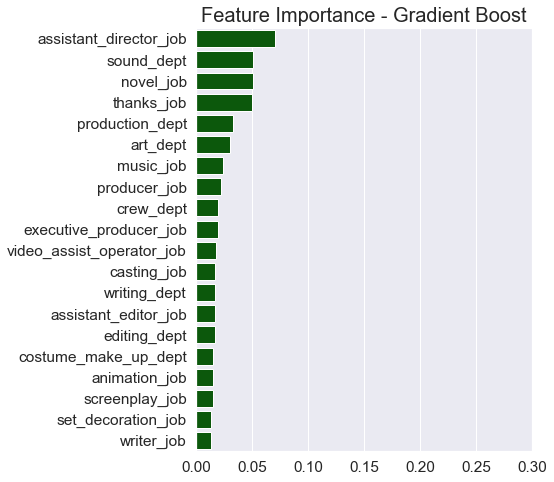

In [68]:
#order = boost_features.features
plt.figure(figsize=(8,7))
sns.set(font_scale=1.4, style='darkgrid')
ax = sns.barplot(x="feature_importance", y='features', color='darkgreen', data=importance)
ax.set(xlabel='',
       ylabel='',
       xlim=(0.0, 0.3)
      )
ax.set_title('Feature Importance - Gradient Boost', fontsize=20)

plt.tight_layout(h_pad=2)

In [260]:
# job_features for ridge
training_scaled = scaler.fit_transform(df_job[job_features])
pipeline = Pipeline([
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', Ridge())
])

parameters = {
    'threshold__threshold': (.001,),
    'features__k': (100,),
    'clf__alpha': (30,),

}
 
                                            
grid_search = GridSearchCV(pipeline, parameters, 
                           cv=3, scoring='neg_mean_squared_error', refit=True)
grid_search.fit(df_job[job_features], df_job['vote_average'])
print( 'Best score: {}'.format(grid_search.best_score_))
print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: {}'.format(grid_search.best_estimator_.get_params()))

Best score: -0.628145536570034
Best score: 0.793
Best parameters: {'memory': None, 'steps': [('threshold', VarianceThreshold(threshold=0.001)), ('features', SelectKBest(k=100, score_func=<function f_regression at 0x1a17129bf8>)), ('clf', Ridge(alpha=30, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))], 'threshold': VarianceThreshold(threshold=0.001), 'features': SelectKBest(k=100, score_func=<function f_regression at 0x1a17129bf8>), 'clf': Ridge(alpha=30, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001), 'threshold__threshold': 0.001, 'features__k': 100, 'features__score_func': <function f_regression at 0x1a17129bf8>, 'clf__alpha': 30, 'clf__copy_X': True, 'clf__fit_intercept': True, 'clf__max_iter': None, 'clf__normalize': False, 'clf__random_state': None, 'clf__solver': 'auto', 'clf__tol': 0.001}


In [270]:
# all for Ridge
training_scaled = scaler.fit_transform(df_job[test_features])
pipeline = Pipeline([
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', Ridge())
])

parameters = {
    'threshold__threshold': (.001,.0005),
    'features__k': ('all',50,100),
    'clf__alpha': (10, 30),

}
 
                                            
grid_search = GridSearchCV(pipeline, parameters, 
                           cv=3, scoring='neg_mean_squared_error', refit=True)
grid_search.fit(training_scaled, df_job['vote_average'])
print( 'Best score: {}'.format(grid_search.best_score_))
print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: {}'.format(grid_search.best_estimator_.get_params()))

Best score: -0.5235590379638666
Best score: 0.724
Best parameters: {'memory': None, 'steps': [('threshold', VarianceThreshold(threshold=0.0005)), ('features', SelectKBest(k='all', score_func=<function f_regression at 0x1a17129bf8>)), ('clf', Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))], 'threshold': VarianceThreshold(threshold=0.0005), 'features': SelectKBest(k='all', score_func=<function f_regression at 0x1a17129bf8>), 'clf': Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001), 'threshold__threshold': 0.0005, 'features__k': 'all', 'features__score_func': <function f_regression at 0x1a17129bf8>, 'clf__alpha': 10, 'clf__copy_X': True, 'clf__fit_intercept': True, 'clf__max_iter': None, 'clf__normalize': False, 'clf__random_state': None, 'clf__solver': 'auto', 'clf__tol': 0.001}


In [264]:
# all for Lasso
training_scaled = scaler.fit_transform(df_job[test_features])
pipeline = Pipeline([
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', Lasso())
])

parameters = {
    'threshold__threshold': (.001,.0005),
    'features__k': ('all',50,100),
    'clf__alpha': (.05,.02, .01, 1,8),

}
 
                                            
grid_search = GridSearchCV(pipeline, parameters, 
                           cv=3, scoring='neg_mean_squared_error', refit=True)
grid_search.fit(df_job[test_features], df_job['vote_average'])
print( 'Best score: {}'.format(grid_search.best_score_))
print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: {}'.format(grid_search.best_estimator_.get_params()))

Best score: -0.5132491526532934
Best score: 0.716
Best parameters: {'memory': None, 'steps': [('threshold', VarianceThreshold(threshold=0.001)), ('features', SelectKBest(k='all', score_func=<function f_regression at 0x1a17129bf8>)), ('clf', Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))], 'threshold': VarianceThreshold(threshold=0.001), 'features': SelectKBest(k='all', score_func=<function f_regression at 0x1a17129bf8>), 'clf': Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), 'threshold__threshold': 0.001, 'features__k': 'all', 'features__score_func': <function f_regression at 0x1a17129bf8>, 'clf__alpha': 0.01, 'clf__copy_X': True, 'clf__fit_intercept': True, 'clf__max_iter': 1000, 'clf__normalize': F

In [258]:
# job_features for Lasso
training_scaled = scaler.fit_transform(df_job[job_features])
pipeline = Pipeline([
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', Lasso())
])

parameters = {
    #'threshold__threshold': (.001,.0005),
    'features__k': ('all',50,100),
    'clf__alpha': (.05,.02, .01, 1,8),

}
 
                                            
grid_search = GridSearchCV(pipeline, parameters, 
                           cv=3, scoring='neg_mean_squared_error', refit=True)
grid_search.fit(df_job[job_features], df_job['vote_average'])
print( 'Best score: {}'.format(grid_search.best_score_))
print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: {}'.format(grid_search.best_estimator_.get_params()))

Best score: -0.6192008315645904
Best score: 0.787
Best parameters: {'memory': None, 'steps': [('threshold', VarianceThreshold(threshold=0.0)), ('features', SelectKBest(k='all', score_func=<function f_regression at 0x1a17129bf8>)), ('clf', Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))], 'threshold': VarianceThreshold(threshold=0.0), 'features': SelectKBest(k='all', score_func=<function f_regression at 0x1a17129bf8>), 'clf': Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), 'threshold__threshold': 0.0, 'features__k': 'all', 'features__score_func': <function f_regression at 0x1a17129bf8>, 'clf__alpha': 0.01, 'clf__copy_X': True, 'clf__fit_intercept': True, 'clf__max_iter': 1000, 'clf__normalize': False, 

In [231]:
best_estimator = grid_search.best_estimator_.fit(scaled_data, df_job['vote_average'])


In [240]:
len(job_features)

427

In [241]:
len(best_estimator.named_steps['features'].get_support())

334

In [239]:
pd.DataFrame({'support':best_estimator.named_steps['features'].get_support(),
              'job_features':job_features})

ValueError: arrays must all be same length

In [233]:
len(best_estimator.named_steps['clf'].feature_importances_)

100

In [213]:
pipeline.named_steps['clf'].

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [212]:
print_feature_importance(job_features, pipeline.named_steps['clf'])

AttributeError: 'RandomForestRegressor' object has no attribute 'best_estimator_'

In [155]:
training_scaled = scaler.fit_transform(df_job[test_features])
pipeline = Pipeline([
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', GradientBoostingRegressor())
])

parameters = {
    'threshold__threshold': (.002, .001),
    'features__k': ('all',100),
    'clf__max_depth': (4, None),
    'clf__n_estimators': (135,),
    'clf__learning_rate': (0.03,),
    'clf__subsample':(0.3,)
}
 
                                            
grid_search = GridSearchCV(pipeline, parameters, 
                           cv=3, scoring='r2', refit=True)
grid_search.fit(scaled_data, df_job['vote_average'])
print( 'Best score: {}'.format(grid_search.best_score_))
print( 'Best parameters: {}'.format(grid_search.best_estimator_.get_params()))

Best score: 0.2870179035267956
Best parameters: {'memory': None, 'steps': [('threshold', VarianceThreshold(threshold=0.001)), ('features', SelectKBest(k='all', score_func=<function f_regression at 0x1a17129bf8>)), ('clf', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.03, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=135, presort='auto', random_state=None,
             subsample=0.3, verbose=0, warm_start=False))], 'threshold': VarianceThreshold(threshold=0.001), 'features': SelectKBest(k='all', score_func=<function f_regression at 0x1a17129bf8>), 'clf': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.03, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes

In [104]:
# Print feature importance:
def print_feature_importance(X_train, model_object):
    features = pd.DataFrame(data={'features':X_train, 
                                   'feature_importance':model_object.best_estimator_.feature_importances_})
    return features.sort_values(by='feature_importance', ascending=False).reset_index(drop=True)

job_pipe = pd.DataFrame(print_feature_importance(job_features, pipe_boost.named_steps['grid']).iloc[:20,:])

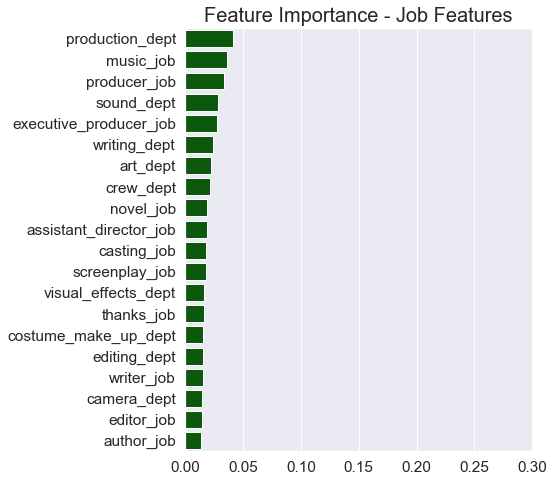

In [121]:
#order = boost_features.features
plt.figure(figsize=(8,7))
sns.set(font_scale=1.4, style='darkgrid')
ax = sns.barplot(x="feature_importance", y='features', color='darkgreen', data=job_pipe)
ax.set(xlabel='',
       ylabel='',
       xlim=(0.0, 0.3)
      )
ax.set_title('Feature Importance - Job Features', fontsize=20)

plt.tight_layout(h_pad=2)

In [115]:
job_filtered = job_features[df_job[job_features].var().sort_values()>0.002]

In [ ]:
SelectKBest(;)

In [112]:
len(job_features)

427

In [119]:
# job_features
X = df_job[job_filtered]

y = df_job['vote_average']


params = {}

pipe_boost = Pipeline(steps=[('scl', MinMaxScaler()), 
#                              ('threshold', VarianceThreshold(0.002)),
#                              ('selectk', SelectKBest(k=100)),
                             ('grid', GridSearchCV(GradientBoostingRegressor(), 
                                               param_grid={'subsample':np.array([0.3])
                                                           ,'learning_rate': np.array([0.03])
                                                           ,'n_estimators': np.array([100]) # 1- 200
                                                           ,'max_depth': np.array([9]) 
                                                          },
                                               cv=3, scoring='r2', refit=True))])

pipe_boost_sqe = Pipeline(steps=[('scl', MinMaxScaler()),
                                 ('threshold', VarianceThreshold(0.002)),
                                 ('selectk', SelectKBest(k='all')),
                                 ('grid', GridSearchCV(GradientBoostingRegressor(), 
                                               param_grid={'subsample':np.array([0.3])
                                                           ,'learning_rate': np.array([0.03])
                                                           ,'n_estimators': np.array([135]) # 1- 200
                                                           ,'max_depth': np.array([4]) 
                                                          },
                                               cv=3, scoring='neg_mean_squared_error', refit=True))])


# Define the parameter values that I would like to search
start_time = time.time()
pipe_boost.fit(X,y)
print(time.time() - start_time)

print("R-squared best parameters: {}".format(pipe_boost.named_steps['grid'].best_params_))
print("R-squared best score: %.3f"%(pipe_boost.named_steps['grid'].best_score_))

pipe_boost_sqe.fit(X,y)
print("Neg Mean Square Error best parameters: {}".format(pipe_boost_sqe.named_steps['grid'].best_params_))
print("Neg Mean Square Error best score: %.3f"%(np.sqrt(pipe_boost_sqe.named_steps['grid'].best_score_*(-1))))

9.709014892578125
R-squared best parameters: {'learning_rate': 0.03, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.3}
R-squared best score: 0.097
Neg Mean Square Error best parameters: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 135, 'subsample': 0.3}
Neg Mean Square Error best score: 0.777


In [30]:
# Define targe and features for this code block
X = df_job[test_features]

y = df_job['vote_average']


params = {}

pipe_boost = Pipeline(steps=[('scl', MinMaxScaler()), 
#                              ('threshold', VarianceThreshold(0.002)),
#                              ('selectk', SelectKBest(k='all')),
                             ('grid', GridSearchCV(GradientBoostingRegressor(), 
                                               param_grid={'subsample':np.array([0.3])
                                                           ,'learning_rate': np.array([0.03])
                                                           ,'n_estimators': np.array([135]) # 1- 200
                                                           ,'max_depth': np.array([4]) 
                                                          },
                                               cv=3, scoring='r2', refit=True))])

pipe_boost_sqe = Pipeline(steps=[('scl', MinMaxScaler()),
                                 ('threshold', VarianceThreshold(0.002)),
                                 ('selectk', SelectKBest(k='all')),
                                 ('grid', GridSearchCV(GradientBoostingRegressor(), 
                                               param_grid={'subsample':np.array([0.3])
                                                           ,'learning_rate': np.array([0.03])
                                                           ,'n_estimators': np.array([135]) # 1- 200
                                                           ,'max_depth': np.array([4]) 
                                                          },
                                               cv=3, scoring='neg_mean_squared_error', refit=True))])


# Define the parameter values that I would like to search
start_time = time.time()
pipe_boost.fit(X,y)
print(time.time() - start_time)

print("R-squared best parameters: {}".format(pipe_boost.named_steps['grid'].best_params_))
print("R-squared best score: %.3f"%(pipe_boost.named_steps['grid'].best_score_))

pipe_boost_sqe.fit(X,y)
print("Neg Mean Square Error best parameters: {}".format(pipe_boost_sqe.named_steps['grid'].best_params_))
print("Neg Mean Square Error best score: %.3f"%(np.sqrt(pipe_boost_sqe.named_steps['grid'].best_score_*(-1))))

6.148070812225342
R-squared best parameters: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 135, 'subsample': 0.3}
R-squared best score: 0.300
Neg Mean Square Error best parameters: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 135, 'subsample': 0.3}
Neg Mean Square Error best score: 0.689


In [24]:
len(df_job[test_features].columns)

243

In [32]:
# Print feature importance:
def print_feature_importance(X_train, model_object):
    features = pd.DataFrame(data={'features':X_train, 
                                   'feature_importance':model_object.best_estimator_.feature_importances_})
    return features.sort_values(by='feature_importance', ascending=False).reset_index(drop=True)


boost_features = pd.DataFrame(print_feature_importance(test_features, pipe_boost.named_steps['grid']).iloc[:20,:])

In [33]:
boost_features

,features,feature_importance
0,runtime,0.205642
1,budget,0.109892
2,year,0.036305
3,music_job,0.035332
4,total_employees,0.034364
5,production_dept,0.021460
6,thanks_job,0.020445
7,visual_effects_dept,0.018919
8,writing_dept,0.015099
9,assistant_director_job,0.014645


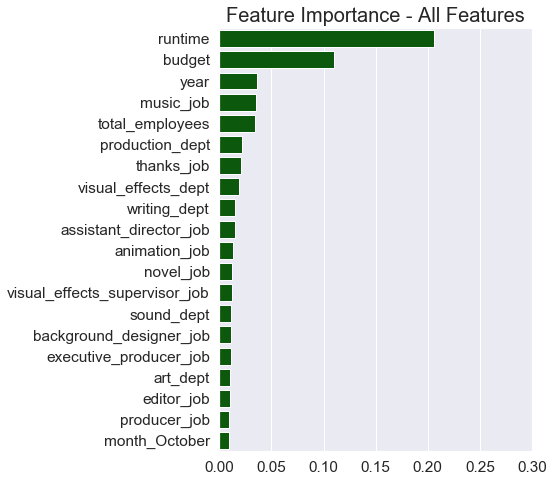

In [122]:
#order = boost_features.features
plt.figure(figsize=(8,7))
sns.set(font_scale=1.4, style='darkgrid')
ax = sns.barplot(x="feature_importance", y='features', color='darkgreen', data=boost_features)
ax.set(xlabel='',
       ylabel='',
       xlim=(0.0, 0.3)
      )
ax.set_title('Feature Importance - All Features', fontsize=20)

plt.tight_layout(h_pad=2)

In [132]:
# Define targe and features for this code block
X = df_job[test_features]

y = df_job['vote_average']


params = {}

pipe_boost = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(GradientBoostingRegressor(), 
                                               param_grid={'subsample':np.array([0.3])
                                                           ,'learning_rate': np.array([0.03])
                                                           ,'n_estimators': np.arange(120, 170, 5) # 1- 200
                                                           ,'max_depth': np.arange(2, 10, 2) 
                                                          },
                                               cv=3, scoring='r2', refit=True))])

pipe_boost_sqe = Pipeline(steps=[('scl', MinMaxScaler()), 
                                 ('grid', GridSearchCV(GradientBoostingRegressor(), 
                                               param_grid={'subsample':np.array([0.3])
                                                           ,'learning_rate': np.array([0.03])
                                                           ,'n_estimators': np.arange(120, 170, 5) # 1- 200
                                                           ,'max_depth': np.arange(2, 10, 2) 
                                                          },
                                               cv=3, scoring='neg_mean_squared_error', refit=True))])


# Define the parameter values that I would like to search
start_time = time.time()
pipe_boost.fit(X,y)
print(time.time() - start_time)

print("R-squared best parameters: {}".format(pipe_boost.named_steps['grid'].best_params_))
print("R-squared best score: %.3f"%(pipe_boost.named_steps['grid'].best_score_))

pipe_boost_sqe.fit(X,y)
print("Neg Mean Square Error best parameters: {}".format(pipe_boost_sqe.named_steps['grid'].best_params_))
print("Neg Mean Square Error best score: %.3f"%(np.sqrt(pipe_boost_sqe.named_steps['grid'].best_score_*(-1))))

39.85977506637573
R-squared best parameters: {'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 135, 'subsample': 0.3}
R-squared best score: 0.290
Neg Mean Square Error best parameters: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 155, 'subsample': 0.3}
Neg Mean Square Error best score: 0.688


In [109]:
test_features = importance['features'][:20].values

In [18]:
## R2
X = df_job[['runtime',  'budget', 'month','year']]
X = pd.get_dummies(X)
y = df_job['vote_average']

score='r2'

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(50, 170,20), # 1- 200
                                                           'max_depth': np.arange(3, 10, 3)},
                                               cv=3,scoring=score,refit=True))])


pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.0001, 1.0, 0.1)},
                                             cv=3,scoring=score,refit=True))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 1, .2)},
                                             cv=3,scoring=score,refit=True))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           #('pca', PCA(n_components=5)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(2, 25, 5)},
                                             cv=3,scoring=score,refit=True))])



# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {'Forest':pipe_forest, 'Lasso':pipe_lasso,'Ridge':pipe_ridge, 'SVM':pipe_svm} #'Ridge':pipe_ridge, 'Lasso':pipe_lasso, '

for pipe in pipe_dict:
    pipe_dict.get(pipe).fit(X, y)
    print('%s  %s: %.3f: %s' % (pipe, score,
                                        pipe_dict.get(pipe).named_steps['grid'].best_score_, 
                                        pipe_dict.get(pipe).named_steps['grid'].best_params_))   

Forest  r2: 0.255: {'max_depth': 6, 'n_estimators': 50}
Lasso  r2: 0.182: {'alpha': 0.0001}
Ridge  r2: 0.182: {'alpha': 0.01}
SVM  r2: 0.195: {'C': 22}


In [20]:
## For mean squared error use inputs from R2
X = df_job[['runtime',  'budget', 'month','year']]
X = pd.get_dummies(X)
y = df_job['vote_average']

score='neg_mean_squared_error'

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.array([50]), # 1- 200
                                                           'max_depth': np.array([6])},
                                               cv=3,scoring=score,refit=True))])


pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.array([0.0001])},
                                             cv=3,scoring=score,refit=True))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.array([.01])},
                                             cv=3,scoring=score,refit=True))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           #('pca', PCA(n_components=5)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.array([22])},
                                             cv=3,scoring=score,refit=True))])



# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {'Forest':pipe_forest, 'Lasso':pipe_lasso,'Ridge':pipe_ridge, 'SVM':pipe_svm} #'Ridge':pipe_ridge, 'Lasso':pipe_lasso, '

for pipe in pipe_dict:
    pipe_dict.get(pipe).fit(X, y)
    print('%s  %s: %.3f: %s' % (pipe, score,
                                        np.sqrt(pipe_dict.get(pipe).named_steps['grid'].best_score_*(-1)), 
                                        pipe_dict.get(pipe).named_steps['grid'].best_params_))   

Forest  neg_mean_squared_error: 0.709: {'max_depth': 6, 'n_estimators': 50}
Lasso  neg_mean_squared_error: 0.741: {'alpha': 0.0001}
Ridge  neg_mean_squared_error: 0.741: {'alpha': 0.01}
SVM  neg_mean_squared_error: 0.735: {'C': 22}


In [63]:
## R2

X = df_job[job_features]

y = df_job['vote_average']

score='r2'

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', MinMaxScaler()), 

                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.array([100]), # 1- 200
                                                           'max_depth': np.array([9])},
                                               cv=3,scoring=score,refit=True))])


# pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
#                              ('grid', GridSearchCV(Lasso(fit_intercept=False),
#                                              param_grid={'alpha':np.arange(0.0001, 1.0, 0.1)},
#                                              cv=3,scoring=score,refit=True))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(5, 10, 5)},
                                             cv=3,scoring=score,refit=True))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           #('pca', PCA(n_components=5)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(2, 20, 5)},
                                             cv=3,scoring=score,refit=True))])



# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {'Forest':pipe_forest}#, 'Ridge':pipe_ridge, 'SVM':pipe_svm} #'Ridge':pipe_ridge, 'Lasso':pipe_lasso, '

for pipe in pipe_dict:
    pipe_dict.get(pipe).fit(X, y)
    print('%s  %s: %.3f: %s' % (pipe, score,
                                        pipe_dict.get(pipe).named_steps['grid'].best_score_, 
                                        pipe_dict.get(pipe).named_steps['grid'].best_params_))   

Forest  r2: 0.095: {'max_depth': 9, 'n_estimators': 160}
Ridge  r2: -7.616: {'alpha': 5}
SVM  r2: 0.078: {'C': 17}


In [67]:
# Print feature importance:
importance = pd.DataFrame(print_feature_importance(job_features, pipe_forest.named_steps['grid']).iloc[:20,:])
importance

,features,feature_importance
0,assistant_director_job,0.069940
1,sound_dept,0.050469
2,novel_job,0.050342
3,thanks_job,0.050034
4,production_dept,0.033009
5,art_dept,0.029688
6,music_job,0.023397
7,producer_job,0.022346
8,crew_dept,0.019336
9,executive_producer_job,0.018924


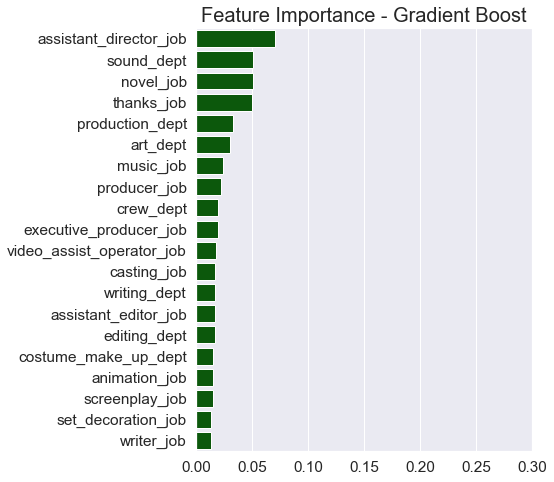

In [68]:
#order = boost_features.features
plt.figure(figsize=(8,7))
sns.set(font_scale=1.4, style='darkgrid')
ax = sns.barplot(x="feature_importance", y='features', color='darkgreen', data=importance)
ax.set(xlabel='',
       ylabel='',
       xlim=(0.0, 0.3)
      )
ax.set_title('Feature Importance - Gradient Boost', fontsize=20)

plt.tight_layout(h_pad=2)

In [92]:
# Print feature importance:
importance = print_feature_importance(X, pipe_forest.named_steps['grid'])
importance

,features,feature_importance
0,runtime,0.362707
1,budget,0.142515
2,total_employees,0.031167
3,Production_dept,0.018322
4,Thanks_job,0.017301
5,Assistant Director_job,0.015251
6,Writing_dept,0.014859
7,Executive Producer_job,0.014751
8,Visual Effects_dept,0.013556
9,Animation_job,0.012955


In [73]:
feature_list = feature_list['features'][:100]
feature_list = list(feature_list)

feature_list.remove('year')

In [224]:
# Root square error

X = df_movies[['runtime','budget','month']]
X = pd.get_dummies(X)
#X = X[['runtime', 'budget', 'month_October', 'month_June', 'month_January']]
y = df_movies['vote_average']
##y = y.astype('int')


score = 'neg_mean_squared_error'
# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', StandardScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(140, 190, 5), # 1- 200
                                                           'max_depth': np.arange(2, 6, 1)}, 
                                               cv=3, scoring=score, refit=True))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.00001, 0.5, 0.005)},
                                             cv=3, scoring=score, refit=True))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, .5, .005)},
                                             cv=3, scoring=score, refit=True))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           #('pca', PCA(n_components=4)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(50, 150, 10)},
                                             cv=3, scoring=score, refit=True))])

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {'Forest':pipe_forest, 'Ridge':pipe_ridge, 'Lasso':pipe_lasso, 'SVM':pipe_svm}

for pipe in pipe_dict:
    pipe_dict.get(pipe).fit(X, y)
    print('%s  %s: %.3f: %s' % (pipe,score,  np.sqrt(pipe_dict.get(pipe).named_steps['grid'].best_score_*(-1)), 
                                        pipe_dict.get(pipe).named_steps['grid'].best_params_))   

Forest  neg_mean_squared_error: 0.713: {'max_depth': 5, 'n_estimators': 155}
Ridge  neg_mean_squared_error: 0.738: {'alpha': 0.01}
Lasso  neg_mean_squared_error: 0.738: {'alpha': 1e-05}
SVM  neg_mean_squared_error: 0.734: {'C': 140}


In [121]:
rfr = RandomForestRegressor(max_depth= 5, n_estimators=130)
cross_val_score(rfr, X, y, cv=5)

array([0.23360199, 0.19471137, 0.1768789 , 0.17400179, 0.28672952])

### Department scored R2

In [69]:
X = df_job[test_features]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = df_job['vote_average']

gbr = GradientBoostingRegressor(max_depth=4, 
                            n_estimators=135,
                               subsample=0.3,
                               learning_rate=0.03) 
gbr_fit = gbr.fit(X_scaled, y)
y_predict = gbr_fit.predict(X_scaled)

output = pd.DataFrame(data={'actual':y, 'prediction':y_predict})

output['residuals'] = output['prediction']-output['actual']

In [70]:
output.head()

,actual,prediction,residuals
movie_id,,,
87567,5.7,5.595670,-0.104330
12177,4.3,5.374631,1.074631
9928,6.0,6.164524,0.164524
109421,6.4,6.061296,-0.338704
8836,5.5,6.075203,0.575203


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


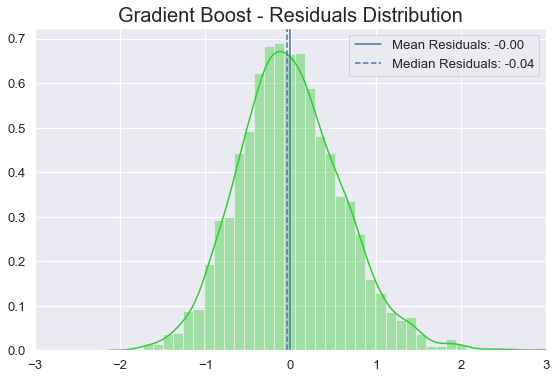

In [87]:
def plot_histogram(data, variable, title):
    # Calculate Descriptive Features
    mean = data.mean()
    median = np.median(data)
    st_dev = np.std(data)
    
    # Set Style of Histogram
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.2,style='darkgrid' )
    ax = sns.distplot(data, color='limegreen', bins=40)
    
    # Set Label Names and Label Font
    ax.set(xlabel='', 
           ylabel=''
           ,xlim=(-3,3))
    ax.set_title(title, fontsize=20)
    
    # Add Vertical Lines and Legend
    axv1 = ax.axvline(mean, label='Mean %s: %4.2f'%(variable, mean))
    axv2 = ax.axvline(median, label='Median %s: %4.2f'%(variable, median), linestyle='--')
#     axv3 = ax.axvline((mean+st_dev), linestyle='--')
#     axv4 = ax.axvline((mean-st_dev), linestyle='--')
    ax.legend()
    
    # Finalize the plot
    #sns.despine(trim=True)
    plt.tight_layout(h_pad=2)
plot_histogram(output['residuals'], 'Residuals', 'Gradient Boost - Residuals Distribution')

(array([ 29., 187., 520., 757., 521., 248.,  74.,  17.,   2.,   2.]),
 array([-1.73478888, -1.25990055, -0.78501222, -0.31012389,  0.16476444,
         0.63965277,  1.1145411 ,  1.58942943,  2.06431776,  2.53920609,
         3.01409441]),
 <a list of 10 Patch objects>)

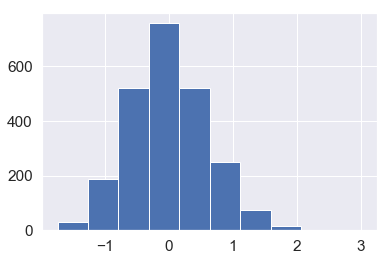

In [71]:
plt.figure(figsize=(8,5))
sns.set(font_scale=1.2,style='darkgrid' )
ax = sns.distplot(data, kde=False, color='limegreen', bins=40)
    
    # Set Label Names and Label Font
    ax.set(xlabel='', 
           ylabel='',
           xlim=(30,200))
    ax.set_title(title, fontsize=20)
    
    # Add Vertical Lines and Legend
    axv1 = ax.axvline(mean, label='Mean %s: %4.2f'%(variable, mean))
    axv2 = ax.axvline(median, label='Median %s: %4.2f'%(variable, median), linestyle='--')
    axv3 = ax.axvline((mean+st_dev), linestyle='--')
    axv4 = ax.axvline((mean-st_dev), linestyle='--')
    ax.legend()
    
    # Finalize the plot
    #sns.despine(trim=True)
    plt.tight_layout(h_pad=2)
plt.hist()

No handles with labels found to put in legend.


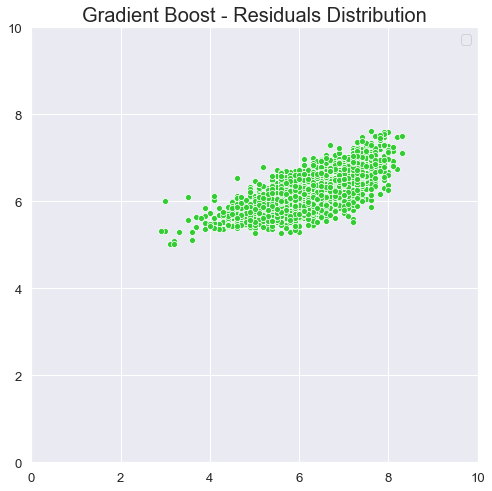

In [95]:
def plot_histogram(data,x,y, title):
    # Calculate Descriptive Features
    mean = data.mean()
    median = np.median(data)
    st_dev = np.std(data)
    
    # Set Style of Histogram
    plt.figure(figsize=(8,8))
    sns.set(font_scale=1.2,style='darkgrid' )
    ax = sns.scatterplot(data=data, x=x, y=y, color='limegreen')
    
    # Set Label Names and Label Font
    ax.set(xlabel='', 
           ylabel='',
           ylim=(0,10)
           ,xlim=(0,10))
    ax.set_title(title, fontsize=20)
    
    ax.legend()
    
    # Finalize the plot
    #sns.despine(trim=True)

plot_histogram(data=output, x='actual', y='prediction', title='Gradient Boost - Residuals Distribution')




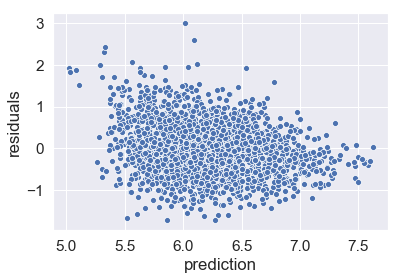

In [73]:
ax=sns.scatterplot(x='prediction', y='residuals', data=output) #output.sort_values(by='actual'))


In [222]:
# neg mean square error combined

X = df_job[list(department_features) + basic_features]
X = pd.get_dummies(X)
scaler = MinMaxScaler()
X_scaler = scaler.fit_transform(X)
y = df_job['vote_average']
##y = y.astype('int')

score = 'neg_mean_squared_error'

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', MinMaxScaler()),
                              #('pca', PCA(n_components=5)),
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 170, 5), # 1- 200
                                                           'max_depth': np.arange(4, 9, 1)}, 
                                               cv=3, scoring=score, refit=True))])


pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 0.4, .05)},
                                             cv=3,scoring=score, refit=True))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 0.4, .05)},
                                             cv=3, scoring=score,refit=True))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           ('pca', PCA(n_components=5)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(20, 50, 5)},
                                             cv=3,scoring=score,refit=True))])

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {'Forest':pipe_forest, 'Ridge':pipe_ridge, 'Lasso':pipe_lasso, 'SVM':pipe_svm}

for pipe in pipe_dict:
    pipe_dict.get(pipe).fit(X, y)
    print('%s  %s: %.3f: %s' % (pipe, score,
                                np.sqrt(pipe_dict.get(pipe).named_steps['grid'].best_score_*(-1)), 
                                pipe_dict.get(pipe).named_steps['grid'].best_params_))  

Forest  neg_mean_squared_error: 0.697: {'max_depth': 7, 'n_estimators': 145}
Ridge  neg_mean_squared_error: 0.731: {'alpha': 0.11}
Lasso  neg_mean_squared_error: 0.794: {'alpha': 0.01}
SVM  neg_mean_squared_error: 0.786: {'C': 45}


In [70]:
# R2 department
feature_columns = df_parsed.department.unique()

X = df_department[feature_columns]
y = df_department['vote_average']
#y = y.astype('int')

score = 'r2'

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', Normalizer()),
                              #('pca', PCA(n_components=5)),
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 170, 5), # 1- 200
                                                           'max_depth': np.arange(1, 6, 1)}, 
                                               cv=3, scoring=score, refit=True))])


pipe_lasso = Pipeline(steps=[#('scl', Normalizer()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 1, .2)},
                                             cv=3,scoring=score, refit=True))])

pipe_ridge = Pipeline(steps=[#('scl', Normalizer()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 1, .2)},
                                             cv=3, scoring=score,refit=True))])

pipe_svm = Pipeline(steps=[('scl', Normalizer()),
                           #('pca', PCA(n_components=5)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(10, 100, 10)},
                                             cv=3,scoring=score,refit=True))])

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {'Forest':pipe_forest, 'Ridge':pipe_ridge, 'Lasso':pipe_lasso, 'SVM':pipe_svm}

for pipe in pipe_dict:
    pipe_dict.get(pipe).fit(X, y)
    print('%s  %s: %.3f: %s' % (pipe, score,
                                pipe_dict.get(pipe).named_steps['grid'].best_score_, 
                                pipe_dict.get(pipe).named_steps['grid'].best_params_))   

Forest  r2: 0.016: {'max_depth': 1, 'n_estimators': 130}
Ridge  r2: -9.004: {'alpha': 0.81}
Lasso  r2: -8.966: {'alpha': 0.21000000000000002}
SVM  r2: -0.014: {'C': 60}


In [64]:
pipe_forest.named_steps['grid'].best_estimator_.feature_importances_

array([0.39036697, 0.24262857, 0.06114636, 0.23155114, 0.07430696])

In [17]:
rfr = RandomForestRegressor(max_depth= 1, n_estimators=135)
cross_val_score(rfr, X, y, cv=5)

array([0.01325711, 0.03208645, 0.01184214, 0.02191061, 0.01865812])

### Rootm Mean Square Error Departments

In [156]:
# Root R2
feature_columns = df_parsed.department.unique()
score = 'r2'

X = df_job[department_features]
y = df_job['vote_average']
#y = y.astype('int')

# Incorporate Gridsearch into a pipeline

pipe_forest = Pipeline(steps=[#('scl', StandardScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 170, 5), # 1- 200
                                                           'max_depth': np.arange(1, 10, 2)}, 
                                               cv=3,scoring=score,refit=True))])

pipe_lasso = Pipeline(steps=[#('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.01, 1.0, 0.01)},
                                             cv=3,scoring=score,refit=True))])

pipe_ridge = Pipeline(steps=[#('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(1.0, 3, .2)},
                                             cv=3,scoring=score,refit=True))])

pipe_svm = Pipeline(steps=[#('scl', MinMaxScaler()),
                           #('pca', PCA(n_components=4)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(50, 100, 10)},
                                             cv=3,scoring=score,refit=True))])

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {'Forest':pipe_forest, 'Ridge':pipe_ridge, 'Lasso':pipe_lasso, 'SVM':pipe_svm}

for pipe in pipe_dict:
    pipe_dict.get(pipe).fit(X, y)
    print('%s  %s: %.3f: %s' % (pipe, score,
                                pipe_dict.get(pipe).named_steps['grid'].best_score_, 
                                pipe_dict.get(pipe).named_steps['grid'].best_params_))   

Forest  r2: 0.025: {'max_depth': 5, 'n_estimators': 145}
Ridge  r2: -8.724: {'alpha': 2.8}
Lasso  r2: -8.713: {'alpha': 0.05}
SVM  r2: -0.436: {'C': 50}


In [ ]:
pip_

In [20]:
# Root Mean Square Error
feature_columns = df_parsed.department.unique()


X = df_job[department_columns]
y = df_job['vote_average']
#y = y.astype('int')

# Incorporate Gridsearch into a pipeline
score = 'r2'
pipe_forest = Pipeline(steps=[#('scl', StandardScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 170, 5), # 1- 200
                                                           'max_depth': np.arange(1, 6, 1)}, 
                                               cv=3,scoring=score,refit=True))])

pipe_lasso = Pipeline(steps=[#('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.00001, 1.0, 0.01)},
                                             cv=3,scoring=score,refit=True))])

pipe_ridge = Pipeline(steps=[#('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 3, .2)},
                                             cv=3,scoring=score,refit=True))])

pipe_svm = Pipeline(steps=[#('scl', MinMaxScaler()),
                           #('pca', PCA(n_components=4)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(50, 150, 10)},
                                             cv=3,scoring=score,refit=True))])

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {'Forest':pipe_forest, 'Ridge':pipe_ridge, 'Lasso':pipe_lasso, 'SVM':pipe_svm}

for pipe in pipe_dict:
    pipe_dict.get(pipe).fit(X, y)
    print('%s  %s: %.3f: %s' % (pipe, score,
                                np.sqrt(pipe_dict.get(pipe).named_steps['grid'].best_score_*(-1)), 
                                pipe_dict.get(pipe).named_steps['grid'].best_params_))   

Forest  neg_mean_squared_error: 0.863: {'max_depth': 1, 'n_estimators': 135}
Ridge  neg_mean_squared_error: 0.868: {'alpha': 0.01}
Lasso  neg_mean_squared_error: 0.868: {'alpha': 1e-05}
SVM  neg_mean_squared_error: 0.881: {'C': 140}


# Job Scaled through Features

In [ ]:
## R2
X = df_movies[['runtime', 'budget']]
y = df_movies['vote_average']
#y = y.astype('int')
score='r2'

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 170, 5), # 1- 200
                                                           'max_depth': np.arange(1, 6, 1)},
                                               cv=3,scoring=score,refit=True))])


pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.0001, 1.0, 0.1)},
                                             cv=3,scoring=score,refit=True))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 2, .2)},
                                             cv=3,scoring=score,refit=True))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           #('pca', PCA(n_components=5)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(50, 150, 10)},
                                             cv=3,scoring=score,refit=True))])



# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {'Forest':pipe_forest, 'Ridge':pipe_ridge, 'Lasso':pipe_lasso, 'SVM':pipe_svm}

for pipe in pipe_dict:
    pipe_dict.get(pipe).fit(X, y)
    print('%s  %s: %.3f: %s' % (pipe, score,
                                        pipe_dict.get(pipe).named_steps['grid'].best_score_, 
                                        pipe_dict.get(pipe).named_steps['grid'].best_params_))   

In [34]:
feature_columns = df_parsed.job.unique()

for col in feature_columns:
    df_jobtitle[col] = df_jobtitle[col]/df_jobtitle['total_employees']
    
X = df_jobtitle[feature_columns]
y = df_jobtitle['vote_average']
#y = y.astype('int')
score = 'r2'

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', Normalizer()), 
                              ('pca', PCA(n_components=20)), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(140, 180, 5), # 1- 200
                                                           'max_depth': np.arange(3, 10, 2)}, 
                                               cv=3,scoring=score,refit=True))])

pipe_lasso = Pipeline(steps=[#('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.01, 1.0, 0.2)},
                                             cv=3,scoring=score,refit=True))])

pipe_ridge = Pipeline(steps=[#('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 2, .2)},
                                             cv=3,scoring=score,refit=True))])

pipe_svm = Pipeline(steps=[#('scl', MinMaxScaler()),
                           ('pca', PCA(n_components=20)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(10, 50, 5)},
                                             cv=3,scoring=score,refit=True))])


# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {'Forest':pipe_forest, 'Ridge':pipe_ridge, 'Lasso':pipe_lasso, 'SVM':pipe_svm}

for pipe in pipe_dict:
    pipe_dict.get(pipe).fit(X, y)
    print('%s  %s: %.3f: %s' % (pipe, score,
                                pipe_dict.get(pipe).named_steps['grid'].best_score_, 
                                pipe_dict.get(pipe).named_steps['grid'].best_params_))   

Forest  r2: 0.024: {'max_depth': 7, 'n_estimators': 155}
Ridge  r2: -36.832: {'alpha': 0.01}
Lasso  r2: -43.134: {'alpha': 0.01}
SVM  r2: -0.022: {'C': 10}


In [41]:
feature_columns = df_parsed.job.unique()

X = job_count[feature_columns]
y = job_count['vote_average']
#y = y.astype('int')

score = 'neg_mean_squared_eror'

# Incorporate Gridsearch into a pipeline
pipe_forest = Pipeline(steps=[('scl', StandardScaler()), 
                         ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 170, 10), # 1- 200
                                                           'max_depth': np.arange(2, 6, 1)}, 
                                               cv=3,scoring=score,refit=True))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.00001, 1.0, 0.01)},
                                             cv=3,scoring=score,refit=True))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 3, .2)},
                                             cv=3,scoring=score,refit=True))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           ('pca', PCA(n_components=10)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(0.5, 8.0, .5)},
                                             cv=3,scoring=score,refit=True))])

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {'Forest':pipe_forest, 'Ridge':pipe_ridge, 'Lasso':pipe_lasso, 'SVM':pipe_svm}

for pipe in pipe_dict:
    pipe_dict.get(pipe).fit(X, y)
    print('%s  %s: %.3f: %s' % (pipe, score,
                                np.sqrt(pipe_dict.get(pipe).named_steps['grid'].best_score_*(-1)), 
                                pipe_dict.get(pipe).named_steps['grid'].best_params_))   

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Random Forest pipeline test R-square: -1.564 with parameters: {'max_depth': 4, 'n_estimators': 160}
Lasso Penalty pipeline test R-square: -6.688 with parameters: {'alpha': 0.01001}
Ridge Penalty pipeline test R-square: -6.931 with parameters: {'alpha': 2.21}
SVM pipeline test R-square: -1.608 with parameters: {'C': 5.0}
Regressor with best negative mean squared error: Random Forest


# Combined Approach

In [100]:
#feature_columns = df_parsed.job.unique()

X = department_count.drop(columns=['title','revenue', 'release_date', 'vote_average', 'random_number', 'vote_count', 'popularity'], axis=1)
y = department_count['vote_average']
#y = y.astype('int')

score = 'r2'
# Incorporate Gridsearch into a pipeline
pipe_forest_pca = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('pca', PCA(n_components=10)),
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 150, 5), # 1- 200
                                                           'max_depth': np.arange(2, 6, 1)}, 
                                               cv=3,scoring=score,refit=True))])

pipe_forest = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 150, 5), # 1- 200
                                                           'max_depth': np.arange(2, 6, 1)}, 
                                               cv=3,scoring=score,refit=True))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.01, 1.0, 0.2)},
                                             cv=3,scoring=score,refit=True))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 2, .2)},
                                             cv=3,scoring=score,refit=True))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           #('pca', PCA(n_components=5)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(8, 18, 2)},
                                             cv=3,scoring=score,refit=True))])


# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {'Forest':pipe_forest, 'Ridge':pipe_ridge, 'Lasso':pipe_lasso, 'SVM':pipe_svm}

for pipe in pipe_dict:
    pipe_dict.get(pipe).fit(X, y)
    print('%s  %s: %.3f: %s' % (pipe, score,
                                pipe_dict.get(pipe).named_steps['grid'].best_score_, 
                                pipe_dict.get(pipe).named_steps['grid'].best_params_))   

Random Forest PCA pipeline test R-square: 0.174 with parameters: {'max_depth': 4, 'n_estimators': 145}
Random Forest pipeline test R-square: 0.202 with parameters: {'max_depth': 4, 'n_estimators': 130}
Regressor with best r squared: Random Forest


In [ ]:
#feature_columns = df_parsed.job.unique()

X = job_count.drop(columns=['title', 'release_date', 'vote_average', 'random_number', 'vote_count', 'popularity'], axis=1)
y = job_count['vote_average']
#y = y.astype('int')

score = 'neg_mean_squared_eror'

# Incorporate Gridsearch into a pipeline
pipe_forest_pca = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('pca', PCA(n_components=20)),
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 150, 5), # 1- 200
                                                           'max_depth': np.arange(2, 6, 1)}, 
                                               cv=3,scoring=score,refit=True))])

pipe_forest = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 150, 5), # 1- 200
                                                           'max_depth': np.arange(1, 6, 1)}, 
                                               cv=3,scoring=score,refit=True))])

pipe_lasso = Pipeline(steps=[('scl', MinMaxScaler()),
                             ('grid', GridSearchCV(Lasso(fit_intercept=False),
                                             param_grid={'alpha':np.arange(0.01, 1.0, 0.2)},
                                             cv=3,scoring=score,refit=True))])

pipe_ridge = Pipeline(steps=[('scl', MinMaxScaler()), 
                             ('grid', GridSearchCV(Ridge(fit_intercept=False),
                                             param_grid={'alpha':np.arange(.01, 2, .2)},
                                             cv=3,scoring=score,refit=True))])

pipe_svm = Pipeline(steps=[('scl', MinMaxScaler()),
                           #('pca', PCA(n_components=5)),
                           ('grid', GridSearchCV(SVR(gamma='auto', kernel='rbf'),
                                             param_grid={'C':np.arange(8, 18, 2)},
                                             cv=3,scoring=score,refit=True))])

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {'Forest':pipe_forest, 'Ridge':pipe_ridge, 'Lasso':pipe_lasso, 'SVM':pipe_svm}

for pipe in pipe_dict:
    pipe_dict.get(pipe).fit(X, y)
    print('%s  %s: %.3f: %s' % (pipe, score,
                                np.sqrt(pipe_dict.get(pipe).named_steps['grid'].best_score_*(-1)), 
                                pipe_dict.get(pipe).named_steps['grid'].best_params_))   

In [101]:

rfr = RandomForestRegressor(max_depth=4, n_estimators=135)
cross_val_score(rfr, X,y,cv=3)

array([0.22702192, 0.22530362, 0.14015337])

In [102]:
features = pd.DataFrame(data={'features':X.columns, 
                              'feature_importance':pipe_forest.named_steps['grid'].best_estimator_.feature_importances_})
features.sort_values(by='feature_importance', ascending=False)

,features,feature_importance
0,runtime,0.422990
1,budget,0.294758
10,Production,0.072200
11,Sound,0.067086
4,Camera,0.042045
8,Editing,0.038881
13,Writing,0.018814
7,Directing,0.016527
6,Crew,0.006983
3,Art,0.006245


In [95]:
pipe_forest.named_steps['grid'].best_score_

0.23075828269295212

In [88]:
X = department_count.drop(columns=['title', 'release_date', 'vote_average', 'random_number', 'vote_count', 'popularity'], axis=1)
y = job_count['vote_average']
#y = y.astype('int')

pipe_forest = Pipeline(steps=[('scl', MinMaxScaler()), 
                              ('grid', GridSearchCV(RandomForestRegressor(), 
                                               param_grid={'n_estimators': np.arange(130, 150, 5), # 1- 200
                                                           'max_depth': np.arange(1, 6, 1)}, 
                                               cv=3,
                                               scoring='r2',
                                               refit=True))])

pipe_forest.fit(X,y)

features = pd.DataFrame(data={'features':X.columns, 
                              'feature_importance':pipe_forest.named_steps['grid'].best_estimator_.feature_importances_})
features.sort_values(by='feature_importance', ascending=False)

,features,feature_importance
13,Visual Effects,0.314286
0,runtime,0.207143
11,Production,0.157143
4,Art,0.107143
1,budget,0.078571
2,revenue,0.057143
14,Writing,0.028571
5,Camera,0.014286
7,Crew,0.014286
8,Directing,0.014286
